In [24]:
import pandas as pd
import numpy as np


In [25]:
import pandas as pd

# Load CSVs
file1 = r"C:\Users\ASUS\OneDrive\Desktop\New folder\new ds\Total Load - Day Ahead _ Actual_2015.csv"
file2 = r"C:\Users\ASUS\OneDrive\Desktop\New folder\new ds\load_forecast_2016_2018.csv"
file3 = r"C:\Users\ASUS\OneDrive\Desktop\New folder\new ds\Total Load - Day Ahead _ Actual_2019.csv"

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df3 = pd.read_csv(file3)

# Rename df1 and df3 to match df2's column names
df1.rename(columns={
    'Time (CET)': 'time',
    'Day-ahead Total Load Forecast [MW] - BZN|ES': 'day_forecast',
    'Actual Total Load [MW] - BZN|ES': 'actual_load'
}, inplace=True)

df3.rename(columns={
    'Time (CET)': 'time',
    'Day-ahead Total Load Forecast [MW] - BZN|ES': 'day_forecast',
    'Actual Total Load [MW] - BZN|ES': 'actual_load'
}, inplace=True)

# Select only the standardized columns
df1 = df1[['time', 'day_forecast', 'actual_load']]
df2 = df2[['time', 'day_forecast', 'actual_load']]
df3 = df3[['time', 'day_forecast', 'actual_load']]

# Merge all
df_combined = pd.concat([df1, df2, df3], ignore_index=True)

# Save to CSV
output_path = r"C:\Users\ASUS\OneDrive\Desktop\New folder\combined_output.csv"
df_combined.to_csv(output_path, index=False)

print("✅ Combined and cleaned file saved successfully at:")
print(output_path)


✅ Combined and cleaned file saved successfully at:
C:\Users\ASUS\OneDrive\Desktop\New folder\combined_output.csv


In [26]:
print(df1.columns)
print(df2.columns)
print(df3.columns)


Index(['time', 'day_forecast', 'actual_load'], dtype='object')
Index(['time', 'day_forecast', 'actual_load'], dtype='object')
Index(['time', 'day_forecast', 'actual_load'], dtype='object')


In [27]:
import pandas as pd

# Load your merged dataset
df = pd.read_csv("combined_output.csv")

# Extract start time (before ' - ')
df['time'] = df['time'].str.extract(r'^(.*?)\s-\s')[0]

# Convert to datetime format
df['time'] = pd.to_datetime(df['time'], format='%d.%m.%Y %H:%M')

# Save cleaned version
df.to_csv("combined_output_clean.csv", index=False)

print("✅ Time column cleaned and saved!")


✅ Time column cleaned and saved!


In [28]:
import pandas as pd

# Step 1: Load the file (raw, even if broken)
file_path = r"C:\Users\ASUS\OneDrive\Desktop\New folder\combined_output.csv"
df_raw = pd.read_csv(file_path, header=None, names=['time', 'actual_load', 'forecast_load'])

# Step 2: Clean the 'time' column
def extract_valid_time(raw_time):
    # Keep only the last timestamp if multiple are present
    parts = str(raw_time).split(',')
    ts = parts[0]
    
    # If it's a range like "31.12.2015 22:00 - 31.12.2015 23:00"
    if " - " in ts:
        ts = ts.split(" - ")[-1].strip()

    # If multiple timestamps are joined
    if " " in ts and ":" in ts and ts.count(":") > 1:
        ts = ts.split()[-2] + " " + ts.split()[-1]

    return ts.strip()

df_raw['time'] = df_raw['time'].apply(extract_valid_time)

# Step 3: Convert to datetime
df_raw['time'] = pd.to_datetime(df_raw['time'], errors='coerce')

# Step 4: Drop rows with invalid datetime or load
df_raw = df_raw.dropna(subset=['time', 'actual_load'])

# Step 5: Convert load values to float
df_raw['actual_load'] = pd.to_numeric(df_raw['actual_load'], errors='coerce')
df_raw['forecast_load'] = pd.to_numeric(df_raw['forecast_load'], errors='coerce')

# Step 6: Drop remaining NaNs
df_raw.dropna(inplace=True)

# Step 7: Sort by time
df_raw = df_raw.sort_values(by='time')

# Optional: Save cleaned version
df_raw.to_csv(r"C:\Users\ASUS\OneDrive\Desktop\New folder\cleaned_combined_output.csv", index=False)

print("✅ Cleaned load data. Shape:", df_raw.shape)
print(df_raw.head())


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10516\3838265117.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_raw['time'] = pd.to_datetime(df_raw['time'], errors='coerce')


✅ Cleaned load data. Shape: (40794, 3)
                 time  actual_load  forecast_load
1 2015-01-01 01:00:00      26118.0        25385.0
2 2015-01-01 02:00:00      24934.0        24382.0
3 2015-01-01 03:00:00      23515.0        22734.0
4 2015-01-01 04:00:00      22642.0        21286.0
5 2015-01-01 05:00:00      21785.0        20264.0


In [30]:
import pandas as pd
import pytz

# Load the weather data
weather_file = r"C:\Users\ASUS\OneDrive\Desktop\New folder\project data\weeather_2013_2019.csv"
weather_df = pd.read_csv(weather_file)

# Convert dt_iso to datetime with specified format and handle ambiguous DST times
weather_df['dt_iso'] = pd.to_datetime(
    weather_df['dt_iso'].str.strip(),
    format="%Y-%m-%d %H:%M:%S %z UTC",
    utc=True
)

# Convert timezone to Europe/Madrid and handle DST ambiguity
weather_df['dt_iso'] = weather_df['dt_iso'].dt.tz_convert('Europe/Madrid')
weather_df['dt_iso'] = weather_df['dt_iso'].dt.tz_localize(None)  # remove timezone if not needed

# Convert temperatures from Kelvin to Celsius
weather_df['temp'] = weather_df['temp'] - 273.15
weather_df['temp_min'] = weather_df['temp_min'] - 273.15
weather_df['temp_max'] = weather_df['temp_max'] - 273.15

# Keep only the relevant columns
weather_df = weather_df[['dt_iso', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all']]

# Rename dt_iso to time for merging
weather_df.rename(columns={'dt_iso': 'time'}, inplace=True)

# Round the time to the nearest hour
weather_df['time'] = pd.to_datetime(weather_df['time']).dt.round('H')

# Save to new CSV
weather_df.to_csv(r"C:\Users\ASUS\OneDrive\Desktop\New folder\new ds\preprocessed_weather.csv", index=False)

print("✅ Weather data cleaned and DST ambiguity resolved.")


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10516\583713952.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_df['time'] = pd.to_datetime(weather_df['time']).dt.round('H')


✅ Weather data cleaned and DST ambiguity resolved.


In [23]:
import pandas as pd
import numpy as np



In [31]:
weather_df = pd.read_csv(r"C:\Users\ASUS\OneDrive\Desktop\New folder\project data\weeather_2013_2019.csv")
load_df = pd.read_csv(r"C:\Users\ASUS\OneDrive\Desktop\New folder\cleaned_combined_output.csv")

In [32]:

weather_df.head()

,Unnamed: 0,dt,dt_iso,city_id,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,0,2013-10-01 02:00:00,2013-10-01 00:00:00 +0000 UTC,2509954,Valencia,299.150000,299.150000,299.150000,1008,61,5,290,0.0,0.0,0.0,20,801,clouds,few clouds,02n
1,1,2013-10-01 03:00:00,2013-10-01 01:00:00 +0000 UTC,2509954,Valencia,298.150000,298.150000,298.150000,1009,65,4,250,0.0,0.0,0.0,20,801,clouds,few clouds,02n
2,2,2013-10-01 04:00:00,2013-10-01 02:00:00 +0000 UTC,2509954,Valencia,296.161000,296.161000,296.161000,1009,71,4,269,0.0,0.0,0.0,10,800,clear,sky is clear,02
3,3,2013-10-01 05:00:00,2013-10-01 03:00:00 +0000 UTC,2509954,Valencia,297.150000,297.150000,297.150000,1008,69,1,250,0.0,0.0,0.0,20,801,clouds,few clouds,02n
4,4,2013-10-01 06:00:00,2013-10-01 04:00:00 +0000 UTC,2509954,Valencia,294.031687,294.031687,294.031687,1009,78,4,288,0.0,0.0,0.0,0,800,clear,sky is clear,01


In [33]:
weather_df.describe()


,Unnamed: 0,city_id,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,263000.000000,2.630000e+05,263000.000000,263000.000000,263000.000000,2.630000e+05,263000.000000,263000.000000,263000.000000,263000.000000,263000.000000,263000.000000,263000.000000,263000.000000
mean,131499.500000,3.649190e+06,289.572567,288.246739,291.049561,1.051124e+03,67.915388,2.510798,170.081323,0.076972,0.005963,0.003238,25.197027,762.370494
std,75921.704736,1.374747e+06,7.912948,7.848858,8.433068,4.916739e+03,21.756214,2.102927,115.670040,0.434235,0.247590,0.183363,30.381443,105.758496
min,0.000000,2.509954e+06,74.037500,74.037500,74.037500,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,65749.750000,3.117735e+06,283.750000,282.510375,285.085000,1.013000e+03,53.000000,1.000000,60.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,131499.500000,3.128026e+06,289.150000,288.150000,290.150000,1.017000e+03,71.000000,2.000000,183.000000,0.000000,0.000000,0.000000,20.000000,800.000000
75%,197249.250000,3.128760e+06,295.150000,293.710000,297.130750,1.022000e+03,87.000000,4.000000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,262999.000000,6.361046e+06,329.250000,315.150000,371.150000,1.008371e+06,100.000000,133.000000,360.000000,16.760000,25.000000,21.500000,100.000000,804.000000


In [34]:
load_df.head()

,time,actual_load,forecast_load
0,2015-01-01 01:00:00,26118.0,25385.0
1,2015-01-01 02:00:00,24934.0,24382.0
2,2015-01-01 03:00:00,23515.0,22734.0
3,2015-01-01 04:00:00,22642.0,21286.0
4,2015-01-01 05:00:00,21785.0,20264.0


In [35]:

load_df.describe()

,actual_load,forecast_load
count,40794.000000,40794.000000
mean,28727.834265,28715.120802
std,4586.080174,4568.431331
min,18105.000000,18041.000000
25%,24822.000000,24841.250000
50%,28913.500000,28919.000000
75%,32263.000000,32192.750000
max,41390.000000,41015.000000


In [36]:
import pandas as pd

# -----------------------------------------------
# STEP 1: Load CSVs
# -----------------------------------------------
# Uncomment and use your actual paths
# load_df = pd.read_csv("combined_output.csv")
# weather_df = pd.read_csv("preprocessed_weather.csv")

# -----------------------------------------------
# STEP 2: Convert time columns to datetime
# -----------------------------------------------
load_df['time'] = pd.to_datetime(load_df['time'], utc=True)

# Convert dt_iso to string first, strip suffix, then convert to datetime
weather_df['dt_iso'] = weather_df['dt_iso'].astype(str).str.replace(' \+0000 UTC', '', regex=True)
weather_df['dt_iso'] = pd.to_datetime(weather_df['dt_iso'], utc=True)

# -----------------------------------------------
# STEP 3: Filter weather data to match load_df range
# -----------------------------------------------
min_time = load_df['time'].min()
max_time = load_df['time'].max()
weather_df = weather_df[(weather_df['dt_iso'] >= min_time) & (weather_df['dt_iso'] <= max_time)]

# -----------------------------------------------
# STEP 4: Resample weather data hourly (mean for each hour)
# -----------------------------------------------
# Set datetime index
weather_df = weather_df.set_index('dt_iso')

# Keep only numeric columns for averaging
numeric_cols = weather_df.select_dtypes(include='number').columns

# Resample hourly
weather_df = weather_df[numeric_cols].resample('H').mean().reset_index()

# -----------------------------------------------
# STEP 5: Rename datetime column to 'time' to match load_df
# -----------------------------------------------
weather_df.rename(columns={'dt_iso': 'time'}, inplace=True)

# -----------------------------------------------
# STEP 6: Select relevant weather features
# -----------------------------------------------
weather_df = weather_df[['time', 'temp', 'temp_min', 'temp_max', 'humidity',
                         'pressure', 'wind_speed', 'wind_deg', 'clouds_all']]

# -----------------------------------------------
# STEP 7: Handle missing values
# -----------------------------------------------
weather_df.fillna(method='ffill', inplace=True)
load_df.fillna(method='ffill', inplace=True)

# -----------------------------------------------
# STEP 8: Merge datasets on 'time'
# -----------------------------------------------
merged_df = pd.merge(load_df, weather_df, on='time', how='inner')

# -----------------------------------------------
# STEP 9: Feature Engineering
# -----------------------------------------------
merged_df['hour'] = merged_df['time'].dt.hour
merged_df['day'] = merged_df['time'].dt.day
merged_df['weekday'] = merged_df['time'].dt.dayofweek
merged_df['month'] = merged_df['time'].dt.month
merged_df['year'] = merged_df['time'].dt.year
merged_df['season'] = merged_df['month'] % 12 // 3 + 1
merged_df['season'] = merged_df['season'].map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'})

# -----------------------------------------------
# STEP 10: Final Check
# -----------------------------------------------
print("✅ Preprocessing complete.")
print("Merged DataFrame shape:", merged_df.shape)
print(merged_df.head())


✅ Preprocessing complete.
Merged DataFrame shape: (39953, 17)
                       time  actual_load  forecast_load        temp  \
0 2015-01-01 01:00:00+00:00      26118.0        25385.0  272.099137   
1 2015-01-01 02:00:00+00:00      24934.0        24382.0  272.089469   
2 2015-01-01 03:00:00+00:00      23515.0        22734.0  272.145900   
3 2015-01-01 04:00:00+00:00      22642.0        21286.0  272.024000   
4 2015-01-01 05:00:00+00:00      21785.0        20264.0  272.058400   

     temp_min    temp_max  humidity  pressure  wind_speed  wind_deg  \
0  272.099137  272.099137      82.0    1016.8         2.4     119.0   
1  272.089469  272.089469      82.0    1016.6         2.4     119.2   
2  272.145900  272.145900      82.0    1016.6         2.4     118.4   
3  272.024000  272.024000      82.6    1017.4         2.4     174.8   
4  272.058400  272.058400      82.6    1017.4         2.4     174.4   

   clouds_all  hour  day  weekday  month  year  season  
0         0.0     1    1   

C:\Users\ASUS\AppData\Local\Temp\ipykernel_10516\1831084256.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_df = weather_df[numeric_cols].resample('H').mean().reset_index()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10516\1831084256.py:52: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_df.fillna(method='ffill', inplace=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10516\1831084256.py:53: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  load_df.fillna(method='ffill', inplace=True)


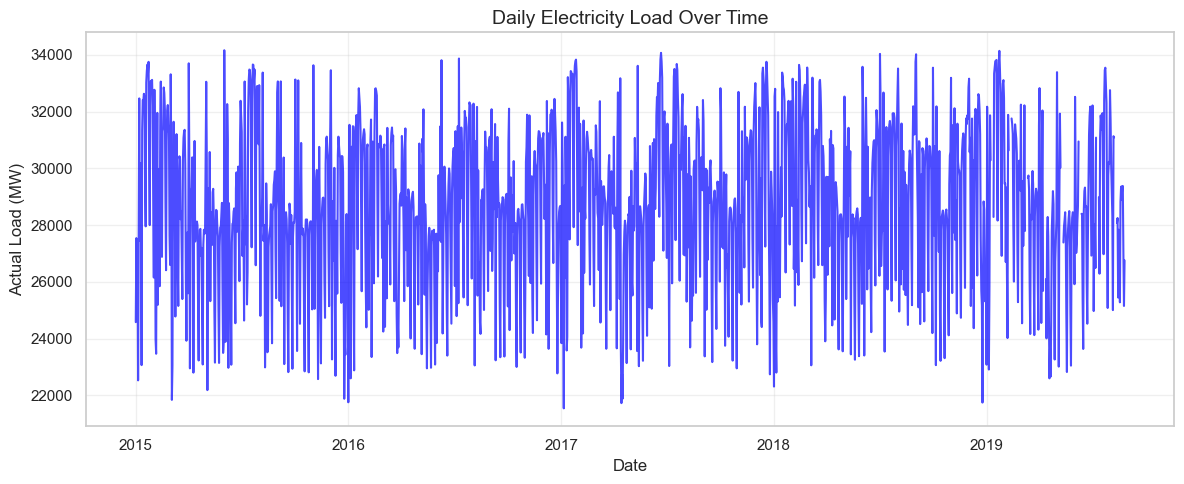

In [47]:
# Downsample to daily average for smoother plot
daily_load = merged_df.resample('D', on='time').mean(numeric_only=True)

plt.figure(figsize=(12, 5))
plt.plot(daily_load.index, daily_load['actual_load'], label='Daily Avg Load', color='blue', alpha=0.7)
plt.title('Daily Electricity Load Over Time', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Actual Load (MW)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



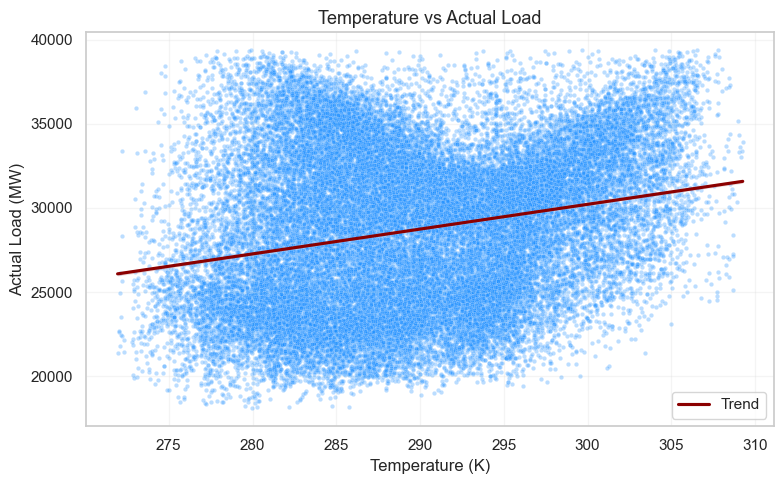

In [48]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x='temp', y='actual_load', 
    data=merged_df, 
    alpha=0.3, s=10, color='dodgerblue'
)
sns.regplot(
    x='temp', y='actual_load', 
    data=merged_df, 
    scatter=False, color='darkred', label='Trend'
)
plt.title('Temperature vs Actual Load', fontsize=13)
plt.xlabel('Temperature (K)')
plt.ylabel('Actual Load (MW)')
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()



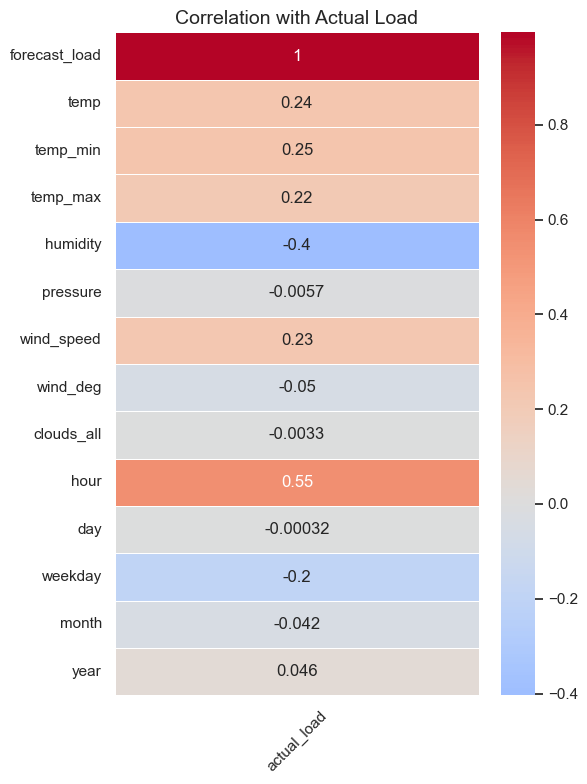

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter correlation with only 'actual_load'
corr = merged_df.select_dtypes(include='number').corr()
load_corr = corr[['actual_load']].drop('actual_load')  # exclude self-correlation

# Plot a simpler heatmap
plt.figure(figsize=(6, 8))
sns.heatmap(load_corr, annot=True, cmap='coolwarm', center=0, linewidths=0.5, cbar=True)
plt.title('Correlation with Actual Load', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




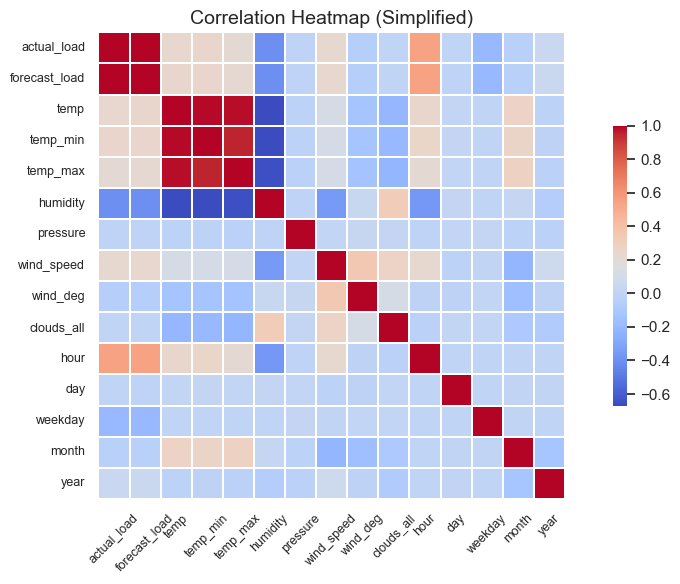

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=False, cmap='coolwarm', linewidths=0.3, square=True, cbar_kws={"shrink": 0.6})
plt.title('Correlation Heatmap', fontsize=14)
plt.xticks(rotation=45, fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()


In [46]:
top_corr = load_corr['actual_load'].abs().sort_values(ascending=False).head(5)
print(top_corr)

forecast_load    0.995297
hour             0.546063
humidity         0.404105
temp_min         0.246348
temp             0.235603
Name: actual_load, dtype: float64


In [14]:
import pandas as pd

# Load raw weather data
weather_df = pd.read_csv(
    r'C:\Users\ASUS\OneDrive\Desktop\New folder\project data\weeather_2013_2019.csv'
)

# Clean 'dt_iso' by removing timezone text and parse it
weather_df['dt_iso'] = weather_df['dt_iso'].str.replace(' \+0000 UTC', '', regex=True)
weather_df['time'] = pd.to_datetime(weather_df['dt_iso'], utc=True, errors='coerce')
weather_df.drop(columns=['dt_iso'], inplace=True)

# Drop invalid datetimes
weather_df.dropna(subset=['time'], inplace=True)
weather_df['time'] = weather_df['time'].dt.floor('h')


In [17]:
weather_df.head()

,Unnamed: 0,dt,city_id,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon,time
0,0,2013-10-01 02:00:00,2509954,Valencia,299.150000,299.150000,299.150000,1008,61,5,290,0.0,0.0,0.0,20,801,clouds,few clouds,02n,2013-10-01 00:00:00+00:00
1,1,2013-10-01 03:00:00,2509954,Valencia,298.150000,298.150000,298.150000,1009,65,4,250,0.0,0.0,0.0,20,801,clouds,few clouds,02n,2013-10-01 01:00:00+00:00
2,2,2013-10-01 04:00:00,2509954,Valencia,296.161000,296.161000,296.161000,1009,71,4,269,0.0,0.0,0.0,10,800,clear,sky is clear,02,2013-10-01 02:00:00+00:00
3,3,2013-10-01 05:00:00,2509954,Valencia,297.150000,297.150000,297.150000,1008,69,1,250,0.0,0.0,0.0,20,801,clouds,few clouds,02n,2013-10-01 03:00:00+00:00
4,4,2013-10-01 06:00:00,2509954,Valencia,294.031687,294.031687,294.031687,1009,78,4,288,0.0,0.0,0.0,0,800,clear,sky is clear,01,2013-10-01 04:00:00+00:00


In [18]:
# Load load data
load_df = pd.read_csv(
    r'C:\Users\ASUS\OneDrive\Desktop\New folder\cleaned_combined_output.csv',
    parse_dates=['time']
)
load_df['time'] = pd.to_datetime(load_df['time'], utc=True, errors='coerce')
load_df['time'] = load_df['time'].dt.floor('h')
load_df.dropna(subset=['time'], inplace=True)

# Merge on 'time'
merged_df = pd.merge(load_df, weather_df, on='time', how='inner')
merged_df.drop(columns=['city_name', 'weather_main', 'weather_description', 'weather_icon'], errors='ignore', inplace=True)
merged_df.dropna(inplace=True)

# Final dataframe for Prophet-style modeling
final_df = merged_df.copy()
final_df.rename(columns={'time': 'ds', 'actual_load': 'y'}, inplace=True)
final_df = final_df.sort_values('ds').reset_index(drop=True)

# Check output
print("Weather time range:", weather_df['time'].min(), "to", weather_df['time'].max())
print("Load time range:", load_df['time'].min(), "to", load_df['time'].max())
print(final_df.head())


Weather time range: 2013-10-01 00:00:00+00:00 to 2019-08-26 00:00:00+00:00
Load time range: 2015-01-01 01:00:00+00:00 to 2019-12-08 23:00:00+00:00
                         ds        y  forecast_load  Unnamed: 0  \
0 2015-01-01 01:00:00+00:00  26118.0        25385.0       11075   
1 2015-01-01 01:00:00+00:00  26118.0        25385.0       63228   
2 2015-01-01 01:00:00+00:00  26118.0        25385.0      116333   
3 2015-01-01 01:00:00+00:00  26118.0        25385.0      169280   
4 2015-01-01 01:00:00+00:00  26118.0        25385.0      221705   

                    dt  city_id        temp    temp_min    temp_max  pressure  \
0  2015-01-01 02:00:00  2509954  269.686000  269.686000  269.686000      1002   
1  2015-01-01 02:00:00  3117735  266.186000  266.186000  266.186000       971   
2  2015-01-01 02:00:00  3128026  269.251688  269.251688  269.251688      1036   
3  2015-01-01 02:00:00  3128760  281.286000  281.286000  281.286000      1036   
4  2015-01-01 02:00:00  6361046  274.086000  

In [19]:
print("Weather time range:", weather_df['time'].min(), "to", weather_df['time'].max())
print("Load time range:", load_df['time'].min(), "to", load_df['time'].max())


Weather time range: 2013-10-01 00:00:00+00:00 to 2019-08-26 00:00:00+00:00
Load time range: 2015-01-01 01:00:00+00:00 to 2019-12-08 23:00:00+00:00


In [20]:
print(final_df.info())
print(final_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203246 entries, 0 to 203245
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   ds             203246 non-null  datetime64[ns, UTC]
 1   y              203246 non-null  float64            
 2   forecast_load  203246 non-null  float64            
 3   Unnamed: 0     203246 non-null  int64              
 4   dt             203246 non-null  object             
 5   city_id        203246 non-null  int64              
 6   temp           203246 non-null  float64            
 7   temp_min       203246 non-null  float64            
 8   temp_max       203246 non-null  float64            
 9   pressure       203246 non-null  int64              
 10  humidity       203246 non-null  int64              
 11  wind_speed     203246 non-null  int64              
 12  wind_deg       203246 non-null  int64              
 13  rain_1h        203246 non-nul

In [21]:
print(final_df.isna().sum())


ds               0
y                0
forecast_load    0
Unnamed: 0       0
dt               0
city_id          0
temp             0
temp_min         0
temp_max         0
pressure         0
humidity         0
wind_speed       0
wind_deg         0
rain_1h          0
rain_3h          0
snow_3h          0
clouds_all       0
weather_id       0
dtype: int64


In [22]:
print(final_df['ds'].min(), "to", final_df['ds'].max())
print(final_df['ds'].diff().value_counts().head())


2015-01-01 01:00:00+00:00 to 2019-08-26 00:00:00+00:00
ds
0 days 00:00:00    163295
0 days 01:00:00     39923
0 days 02:00:00        16
4 days 01:00:00         8
0 days 07:00:00         1
Name: count, dtype: int64


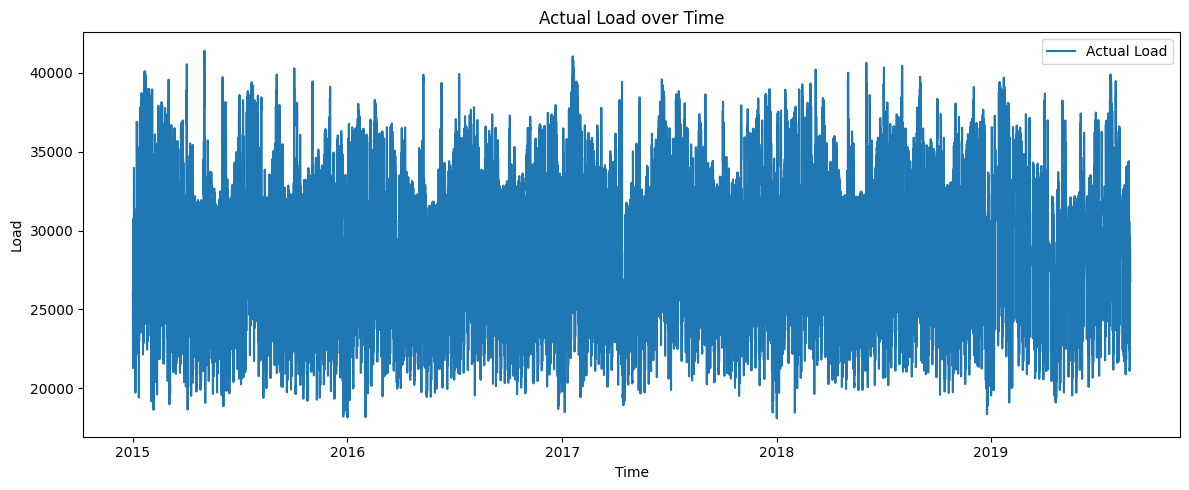

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(final_df['ds'], final_df['y'], label='Actual Load')
plt.xlabel("Time")
plt.ylabel("Load")
plt.title("Actual Load over Time")
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
print(final_df[['ds', 'y']].dtypes)
print(final_df[['ds', 'y']].head(10))
print(final_df[['ds', 'y']].describe())


ds    datetime64[ns, UTC]
y                 float64
dtype: object
Empty DataFrame
Columns: [ds, y]
Index: []
         y
count  0.0
mean   NaN
std    NaN
min    NaN
25%    NaN
50%    NaN
75%    NaN
max    NaN


In [25]:
final_df.head(10)

,ds,y,forecast_load,Unnamed: 0,dt,city_id,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
0,2015-01-01 01:00:00+00:00,26118.0,25385.0,11075,2015-01-01 02:00:00,2509954,269.686000,269.686000,269.686000,1002,78,0,23,0.0,0.0,0.0,0,800
1,2015-01-01 01:00:00+00:00,26118.0,25385.0,63228,2015-01-01 02:00:00,3117735,266.186000,266.186000,266.186000,971,64,1,273,0.0,0.0,0.0,0,800
2,2015-01-01 01:00:00+00:00,26118.0,25385.0,116333,2015-01-01 02:00:00,3128026,269.251688,269.251688,269.251688,1036,97,1,224,0.0,0.0,0.0,0,800
3,2015-01-01 01:00:00+00:00,26118.0,25385.0,169280,2015-01-01 02:00:00,3128760,281.286000,281.286000,281.286000,1036,100,7,48,0.0,0.0,0.0,0,800
4,2015-01-01 01:00:00+00:00,26118.0,25385.0,221705,2015-01-01 02:00:00,6361046,274.086000,274.086000,274.086000,1039,71,3,27,0.0,0.0,0.0,0,800
5,2015-01-01 02:00:00+00:00,24934.0,24382.0,11076,2015-01-01 03:00:00,2509954,269.686000,269.686000,269.686000,1002,78,0,23,0.0,0.0,0.0,0,800
6,2015-01-01 02:00:00+00:00,24934.0,24382.0,63229,2015-01-01 03:00:00,3117735,266.186000,266.186000,266.186000,971,64,1,273,0.0,0.0,0.0,0,800
7,2015-01-01 02:00:00+00:00,24934.0,24382.0,116334,2015-01-01 03:00:00,3128026,269.203344,269.203344,269.203344,1035,97,1,225,0.0,0.0,0.0,0,800
8,2015-01-01 02:00:00+00:00,24934.0,24382.0,169281,2015-01-01 03:00:00,3128760,281.286000,281.286000,281.286000,1036,100,7,48,0.0,0.0,0.0,0,800
9,2015-01-01 02:00:00+00:00,24934.0,24382.0,221706,2015-01-01 03:00:00,6361046,274.086000,274.086000,274.086000,1039,71,3,27,0.0,0.0,0.0,0,800


In [24]:
final_df.to_csv(r"C:\Users\ASUS\OneDrive\Desktop\New folder\final_load_weather_data.csv", index=False)

In [1]:
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv(r"C:\Users\ASUS\OneDrive\Desktop\New folder\final_load_weather_data.csv")

In [3]:
df.head()


,ds,y,forecast_load,Unnamed: 0,dt,city_id,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
0,2015-01-01 01:00:00+00:00,26118.0,25385.0,11075,2015-01-01 02:00:00,2509954,269.686000,269.686000,269.686000,1002,78,0,23,0.0,0.0,0.0,0,800
1,2015-01-01 01:00:00+00:00,26118.0,25385.0,63228,2015-01-01 02:00:00,3117735,266.186000,266.186000,266.186000,971,64,1,273,0.0,0.0,0.0,0,800
2,2015-01-01 01:00:00+00:00,26118.0,25385.0,116333,2015-01-01 02:00:00,3128026,269.251688,269.251688,269.251688,1036,97,1,224,0.0,0.0,0.0,0,800
3,2015-01-01 01:00:00+00:00,26118.0,25385.0,169280,2015-01-01 02:00:00,3128760,281.286000,281.286000,281.286000,1036,100,7,48,0.0,0.0,0.0,0,800
4,2015-01-01 01:00:00+00:00,26118.0,25385.0,221705,2015-01-01 02:00:00,6361046,274.086000,274.086000,274.086000,1039,71,3,27,0.0,0.0,0.0,0,800


In [6]:
from prophet import Prophet
import pandas as pd

# Prophet needs only 'ds' and 'y'
prophet_df = df[['ds', 'y']].copy()

# Initialize and fit
model = Prophet()
model.fit(prophet_df)

# Future dataframe: 168 hours (1 week)
future = model.make_future_dataframe(periods=168, freq='H')
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
model.plot_components(forecast)


ValueError: Column ds has timezone specified, which is not supported. Remove timezone.

In [7]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Set index to datetime
df_arima = df.set_index('ds')

# Fit ARIMA model (adjust order as needed)
model = ARIMA(df_arima['y'], order=(5,1,2))
results = model.fit()

# Forecast next 168 hours
forecast = results.forecast(steps=168)

# Plot
plt.figure(figsize=(12,6))
plt.plot(df_arima['y'], label='Historical')
plt.plot(forecast.index, forecast, label='ARIMA Forecast')
plt.legend()
plt.show()


ModuleNotFoundError: No module named 'statsmodels'